## Problem Statement
* In general, smart home technologies have a tendency to tender good quality for temperature, relative humidity and pressure in a real time manner. However, it may cause more computational operations and more security problems (data goes one part home to another location everytime). Alternatively, we can create a recomendatiton system to navigate users in a better way. If our all metrics is enough to construct an automation system, it can be a better alternative than the real time smart home systems.
* According to my research , smart homes needs data in some interval such as hourly or 10 minutes. In this work, I tried to find temperature, air pressure and relative humidity forecast of living room in 10 minutes intervals.
* The data come from China. It includes weather infromations for 6 room as well as outdoor weather data. Also, it has power consumption data. We can access via this link:
> https://springernature.figshare.com/articles/dataset/The_CN-OBEE_dataset_occupant_behavior_thermal_environment_and_appliance_electricity_use_of_a_single-family_apartment_in_China/23686476
* If you want to know more you can get it via this this:
>https://www.nature.com/articles/s41597-023-02891-9

##Data Preparation
This section includes:
* Importing libraries
* Data uploading
* Outdoor_weather `time` column arrangement and concatenation
> Outdoor_weather dataset has hourly time intervals. However, other datasets has minutely time intervals. We assume that on the same hour weather values are the same.
* Adding air conditioner data into other datasets
* Check object types and arrange them
* Check None or Null rates and arrange them
* Arrange data interaval of 10 minutes

In [74]:
# Import libraries
from google.colab import drive
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import keras
import tensorflow as tf
from keras.models import Sequential
from keras import layers,regularizers
from tensorflow.keras import optimizers
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import json
import csv
from enum import auto

In [ ]:
# Zip documentations
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/smart_home_project/The CN-OBEE dataset.zip"
extract_path = "/content/extracted_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

data_directory = "/content/extracted_data"

Mounted at /content/drive


In [ ]:
# Upload Datasets
mutual_dir = "/content/extracted_data/The CN-OBEE dataset/"
cloakroom = pd.read_csv(mutual_dir + "Cloakroom.csv")
home_office = pd.read_csv(mutual_dir + "Home_office.csv")
kitchen = pd.read_csv(mutual_dir + "Kitchen.csv")
living_room = pd.read_csv(mutual_dir + "Living_room.csv")
master_bedroom = pd.read_csv(mutual_dir + "Master_bedroom.csv")
outdoor_weather = pd.read_csv(mutual_dir + "Outdoor_weather.csv")
power = pd.read_csv(mutual_dir + "Power.csv")
secondary_bedroom = pd.read_csv(mutual_dir + "Secondary_bedroom.csv")

In [ ]:
# Prepare outdoor for other datasets
outdoor_weather['time'] = pd.to_datetime(outdoor_weather['time'])

outdoor_weather.set_index('time', inplace=True)
outdoor_weather = outdoor_weather.resample('T').ffill()
outdoor_weather.reset_index(inplace=True)

In [ ]:
# Add another power consumptions . These information is provided by data sender.
home_office['computer'] = power['computer']
living_room['TV'] = power['TV']
living_room['electric kettle'] = power['electric kettle']
kitchen['rice cooker'] = power['rice cooker']
kitchen['fridge'] = power['fridge']
home_office['air conditioner'] = power['air conditioner#4']
kitchen['air conditioner'] = power['air conditioner#6']
secondary_bedroom['air conditioner'] = power['air conditioner#2']

rooms = [cloakroom, home_office, kitchen, living_room, master_bedroom, secondary_bedroom]

In [ ]:
# Concatenate outdoor_weather with other datasets
outdoor_weather['time'] = pd.to_datetime(outdoor_weather['time'])

for i, room in enumerate(rooms):
    room['time'] = pd.to_datetime(room['time'])
    rooms[i] = pd.merge(room, outdoor_weather, on='time', how='inner')
    rooms[i].index.name = None

In [ ]:
# Check if there is any object type variable
for room_number, room in enumerate(rooms, start=1):
  print(f"---------Room: {room_number}---------")
  for column_name in room.columns:
   if room[column_name].dtypes == object:
      print(f"{column_name}: Object type.")

---------Room: 1---------
wind direction: Object type.
---------Room: 2---------
wind direction: Object type.
---------Room: 3---------
wind direction: Object type.
---------Room: 4---------
wind direction: Object type.
---------Room: 5---------
wind direction: Object type.
---------Room: 6---------
wind direction: Object type.


In [ ]:
# Get rid of object variable
label_encoder = LabelEncoder()

for i, room in enumerate(rooms):
  rooms[i]['wind_direction_encoded'] = label_encoder.fit_transform(room['wind direction'])
  rooms[i].drop(columns=['wind direction'], inplace=True)

In [ ]:
# Check None values rates
room_number = 1
for room in rooms:
  print()
  print(f"---------Room: {room_number}---------")
  for column in room.columns:
    rate = round(room[column].isna().sum() * 100 / len(room[column]), 2)
    if rate != 0:
      print(f"{column}: {rate}%")
  room_number += 1


---------Room: 1---------
dry-bulb temperature (°C)_x: 2.38%
relative humidity (%)_x: 2.38%
air pressure (Pa): 2.38%
occupancy presence (0/1): 0.02%
horizontal total solar radiation intensity (W/m2): 5.19%
horizontal diffuse solar radiation intensity (W/m2): 5.19%

---------Room: 2---------
dry-bulb temperature (°C)_x: 2.14%
relative humidity (%)_x: 2.14%
air pressure (Pa): 2.14%
window state (0/1): 0.27%
east window state (0/1): 1.89%
occupancy presence (0/1): 4.53%
computer: 1.95%
air conditioner: 2.69%
horizontal total solar radiation intensity (W/m2): 5.19%
horizontal diffuse solar radiation intensity (W/m2): 5.19%

---------Room: 3---------
dry-bulb temperature (°C)_x: 2.5%
relative humidity (%)_x: 2.5%
air pressure (Pa): 2.5%
window state (0/1): 0.02%
occupancy presence (0/1): 0.05%
rice cooker: 57.38%
fridge: 1.71%
air conditioner: 1.72%
horizontal total solar radiation intensity (W/m2): 5.19%
horizontal diffuse solar radiation intensity (W/m2): 5.19%

---------Room: 4---------

In [ ]:
# I cannot handle None values of 5th room . I am not going to examine it.
del rooms[4]
rooms_original = [cloakroom, home_office, kitchen, living_room, secondary_bedroom]

In [ ]:
# Now, I can fill None values with median
for room_number, room in enumerate(rooms, start=1):
  for column in room.columns:
    if room[column].dtypes != 'object':
      median_value = room[column].median()
      room[column].fillna(median_value, inplace=True)

In [ ]:
# Check None values rates again
room_number = 1
for room in rooms:
  print()
  print(f"---------Room: {room_number}---------")
  for column in room.columns:
    rate = round(room[column].isna().sum() * 100 / len(room[column]), 2)
    if rate != 0:
      print(f"{column}: {rate}%")
  room_number += 1


---------Room: 1---------

---------Room: 2---------

---------Room: 3---------

---------Room: 4---------

---------Room: 5---------


> Now everything is numerical. From now on, for the sake of simplicity, let's only work on `10 minutes` dataset.

In [ ]:
for i, room in enumerate(rooms):
  room.set_index('time', inplace=True)
  rooms[i] = room.resample('10T').mean()

##Data Visualization
* Plot `temperature` for 10 days in living room

In [ ]:
# Moving Averages Function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotMovingAverage(series, window, plot_average=False ,plot_intervals=False, scale=1.96, plot_anomalies=False):

  """
      series - dataframe with timeseries
      window - rolling window size
      plot_average - show moving average
      plot_intervals - show confidence intervals
      plot_anomalies - show anomalies
  """
  plt.figure(figsize=(25,5))

  rolling_mean = series.rolling(window=window).mean()

  if plot_average:
    plt.title("Moving average with window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

  if not plot_average:
    plt.title("Window size = {}".format(window))

  # Plot confidence intervals for smoothed values
  if plot_intervals:
    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    deviation = np.std(series[window:] - rolling_mean[window:])
    lower_bond = rolling_mean - (mae + scale * deviation)
    upper_bond = rolling_mean + (mae + scale * deviation)
    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")

    # Having the intervals, find abnormal values
    if plot_anomalies:
      series_df = pd.DataFrame(series)
      anomalies = pd.DataFrame(index=series_df.index, columns= series_df.columns)
      anomalies[series < lower_bond] = series_df[series < lower_bond]
      anomalies[series > upper_bond] = series_df[series > upper_bond]
      plt.plot(anomalies, "ro", markersize=10, label="Anomalies")

  plt.plot(series[window:], label="Actual values")
  plt.legend(loc="upper left")
  plt.grid(True)


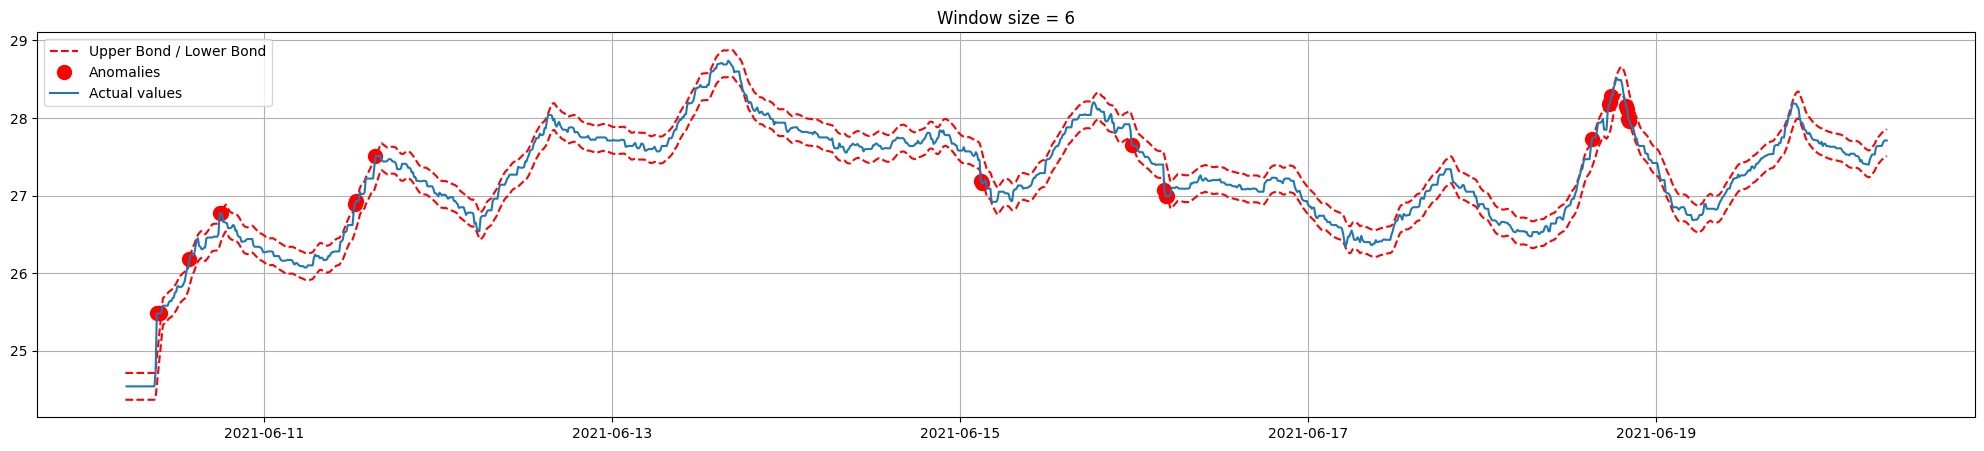

In [ ]:
n_samples = len(rooms[3]['dry-bulb temperature (°C)_x'])//36 # 10 day interval
# Plot with Anomaly detection
plotMovingAverage(rooms[3]['dry-bulb temperature (°C)_x'][n_samples:2*n_samples], window=6,plot_intervals=True, plot_anomalies=True)

## Feature Engineering
* Add information sessions(winter,spring,summer,autumn)
* Visualize correlation matrix

In [ ]:
for i, room in enumerate(rooms):
  seasion_info = np.zeros(len(rooms[i])) # winter 0 ; spring 1 ; summer 2; autumn 3
  var_seasion = 0
  for row in range(len(seasion_info)):
    if 13176 >var_seasion:
      seasion_info[row] = 2
    if 26353 >var_seasion >=13176:
      seasion_info[row] = 3
    if var_seasion >=39529:
      seasion_info[row] = 1
    var_seasion +=1
  rooms[i]['seasion info'] = seasion_info

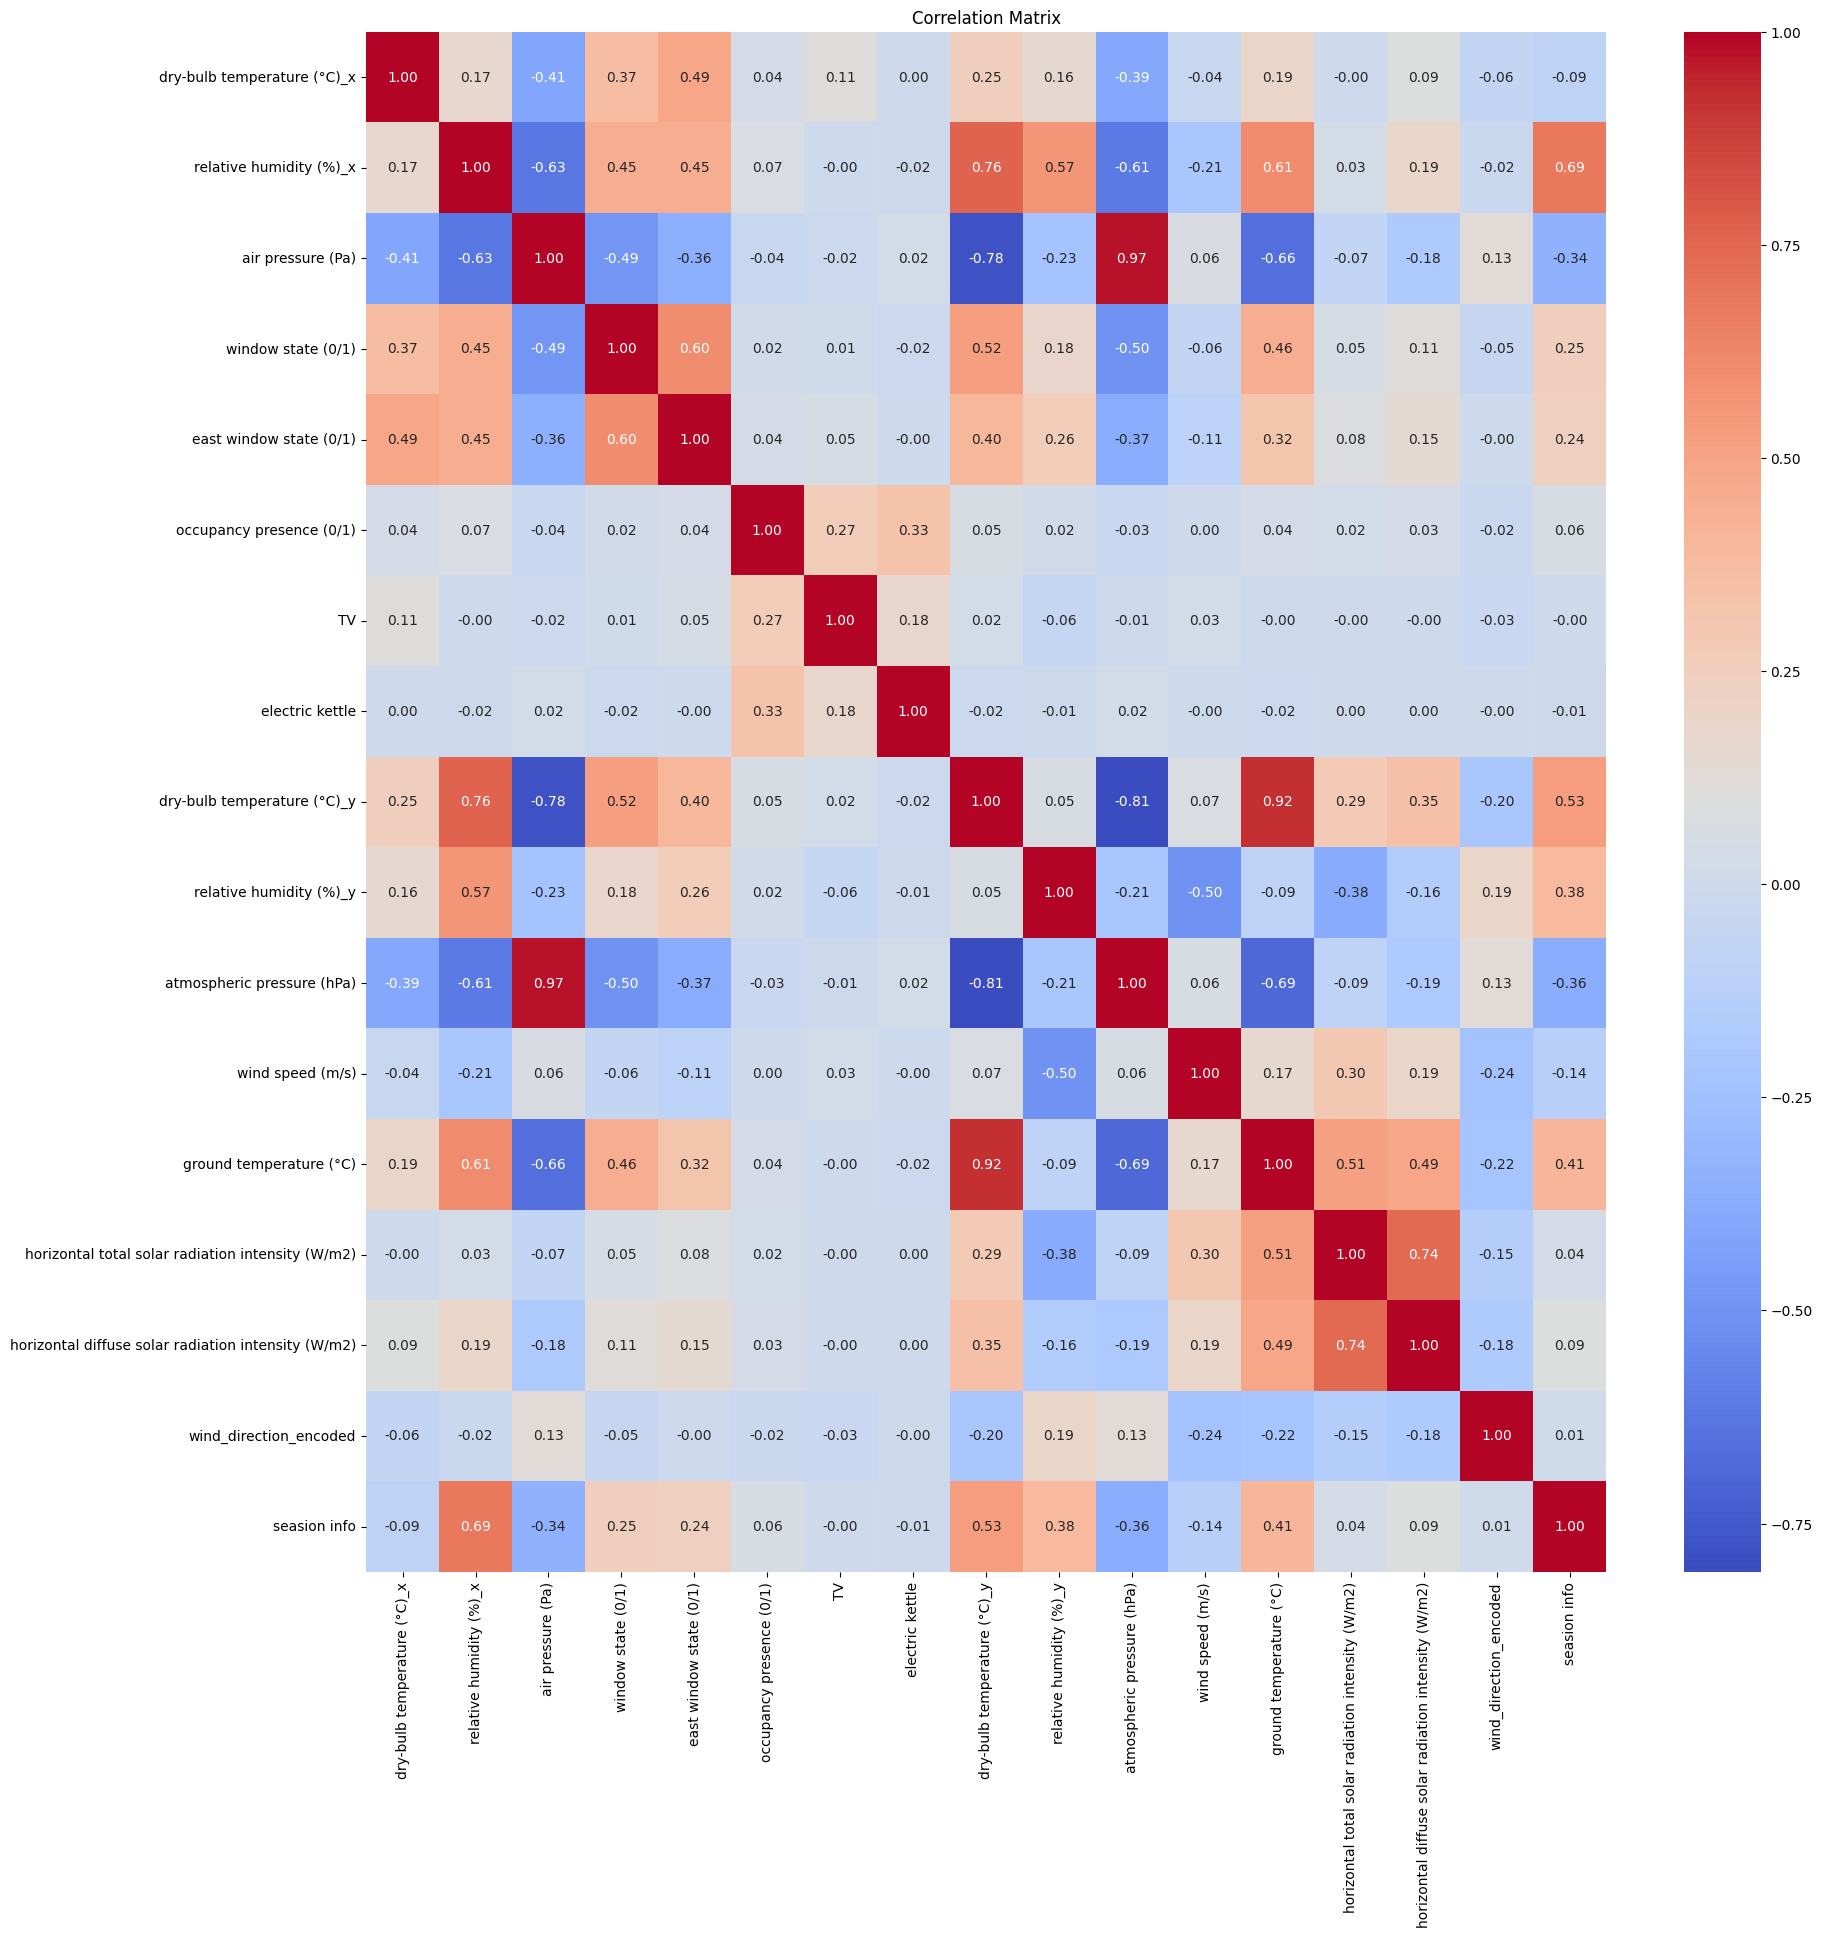

In [ ]:
# Visualize database correlation
def plotCorrelation(data):
  correlation_matrix = data.corr()

  plt.figure(figsize=(20, 20))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
  plt.title('Correlation Matrix')
  plt.show()
plotCorrelation(rooms[3])

## Data Preprocessing
* Scale data with Min-Max Scaller


In [ ]:
# Min Max Scalling
scaler = MinMaxScaler()

for i, room in enumerate(rooms):
  for column in room.columns:
    data_2d = room[column].values.reshape(-1, 1)

    scaled_columns = scaler.fit_transform(data_2d)

    rooms[i][column] = scaled_columns

## Generators and Model Constructioning
* Data Preprations according to correlation matrix
* Create Generators
* Model Constructing
* Create a function `finish` all tasks

In [ ]:
# Arrange temperature dataset
try:
  temp_columns =['dry-bulb temperature (°C)_x', 'relative humidity (%)_x',
                'air pressure (Pa)', 'window state (0/1)','east window state (0/1)',
                'occupancy presence (0/1)', 'TV','wind speed (m/s)',
                'dry-bulb temperature (°C)_y']
  temp_data = [rooms[i][temp_columns] for i in range(len(rooms))]
except:
  temp_columns =['dry-bulb temperature (°C)_x', 'relative humidity (%)_x',
                'air pressure (Pa)', 'wind speed (m/s)',
                'occupancy presence (0/1)', 'dry-bulb temperature (°C)_y']
  temp_data = [rooms[i][temp_columns] for i in range(len(rooms))]
# Arrange Humidity dataset
try:
  humidity_columns = ['dry-bulb temperature (°C)_x', 'relative humidity (%)_x',
                    'air pressure (Pa)', 'window state (0/1)',
                    'occupancy presence (0/1)','seasion info',
                    'dry-bulb temperature (°C)_y', 'relative humidity (%)_y',
                    'wind speed (m/s)']
  humidity_data = [rooms[i][humidity_columns] for i in range(len(rooms))]
except:
  humidity_columns = ['dry-bulb temperature (°C)_x', 'relative humidity (%)_x',
                    'air pressure (Pa)', 'relative humidity (%)_y',
                    'occupancy presence (0/1)','seasion info',
                    'dry-bulb temperature (°C)_y', 'wind speed (m/s)']
  humidity_data = [rooms[i][humidity_columns] for i in range(len(rooms))]
# Arrange Pressure dataset
pressure_columns = ['dry-bulb temperature (°C)_x', 'relative humidity (%)_x',
                    'air pressure (Pa)','wind speed (m/s)','wind_direction_encoded',
                    'occupancy presence (0/1)', 'relative humidity (%)_y',
                    'dry-bulb temperature (°C)_y','horizontal diffuse solar radiation intensity (W/m2)']
pressure_data = [rooms[i][pressure_columns] for i in range(len(rooms))]

In [ ]:
# Generator function
def test_generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6,column_number=0):

  if max_index is None:
    max_index = len(data)- delay- 1

  i = min_index + lookback

  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)

    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)

    samples = np.zeros((len(rows),
                        lookback // step,
                        data.shape[-1]))
    targets = np.zeros((len(rows),))

    for j, row in enumerate(rows):
      indices = range(rows[j]- lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][column_number]
    return samples, targets

def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6, column_number=0):

  if max_index is None:
    max_index = len(data)- delay- 1

  i = min_index + lookback

  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)

    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)

    samples = np.zeros((len(rows),
                        lookback // step,
                        data.shape[-1]))
    targets = np.zeros((len(rows),))

    for j, row in enumerate(rows):
      indices = range(rows[j]- lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][column_number]
    yield samples, targets

In [ ]:
# Create Generators
lookback = 1140 #  10 day
step = 3 # 30 minutes interval
delay = 144 # 1 day
batch_size = 128

train_gen_list = [[],[],[],[],[]]
val_gen_list = [[],[],[],[],[]]
test_gen_list = [[],[],[],[],[]]

train_split = len(rooms[3])*70//100
val_split = train_split + len(rooms[3])*15//100

val_steps = (val_split- train_split- 1 - lookback)
test_steps = (len(rooms[3])- val_split-1 - lookback)

#Train generators
def get_train_gen(data,column_number,room_number):
  train_gen = generator(data.to_numpy(),
                          lookback=lookback,
                          delay=delay,
                          min_index=0,
                          max_index=train_split,
                          shuffle=True,
                          step=step,
                          batch_size=batch_size,
                          column_number=column_number)
  train_gen_list[room_number].append(train_gen)

# Validation generators
def get_val_gen(data,column_number,room_number):
  val_gen = generator(data.to_numpy(),
                          lookback=lookback,
                          delay=delay,
                          min_index=train_split+1,
                          max_index=val_split,
                          step=step,
                          batch_size=batch_size,
                          column_number=column_number)
  val_gen_list[room_number].append(val_gen)

# Test Generators
def get_test_gen(data,column_number,room_number):
  test_gen = test_generator(data.to_numpy(),
                          lookback=lookback,
                          delay=delay,
                          min_index=val_split+1,
                          max_index=None,
                          step=step,
                          batch_size=61*batch_size,
                          column_number=column_number)
  test_gen_list[room_number].append(test_gen)

for i in range(len(rooms)):
  get_train_gen(temp_data[i],0,i)
  get_train_gen(humidity_data[i],1,i)
  get_train_gen(pressure_data[i],2,i)

  get_val_gen(temp_data[i],0,i)
  get_val_gen(humidity_data[i],1,i)
  get_val_gen(pressure_data[i],2,i)

  get_test_gen(temp_data[i],0,i)
  get_test_gen(humidity_data[i],1,i)
  get_test_gen(pressure_data[i],2,i)

In [ ]:
# Model function
def build_model(model_name,shape, isAlternative=False):

  model = Sequential()

  if model_name =='LSTM':
    model.add(layers.LSTM(20,return_sequences=True, input_shape=(None, shape),kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.LSTM(10,return_sequences=False,kernel_regularizer=regularizers.l2(0.01)))

  elif model_name =='GRU' and not isAlternative:
    model.add(layers.GRU(25,return_sequences=True, input_shape=(None, shape),kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.GRU(13,return_sequences=False,kernel_regularizer=regularizers.l2(0.01)))

  elif model_name =='GRU' and isAlternative:
    model.add(layers.GRU(20,return_sequences=True, input_shape=(None, shape),kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.GRU(10,return_sequences=False,kernel_regularizer=regularizers.l2(0.01)))

  model.add(layers.Dense(1))

  return model

In [ ]:
# Pass GPU devices
device = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
print("Device available for TensorFlow usage:",device)

Device available for TensorFlow usage: GPU


In [ ]:
callbacks_list = [
                  keras.callbacks.ReduceLROnPlateau(
                  monitor='val_loss',
                  factor=0.1,
                  patience=1,
                  ),
                  ]

In [ ]:
def min_max_assigner(room_number):
  room = rooms_original[room_number]
  min_value_temp = room['dry-bulb temperature (°C)'].min()
  max_value_temp = room['dry-bulb temperature (°C)'].max()
  min_value_humidity = room['relative humidity (%)'].min()
  max_value_humidity = room['relative humidity (%)'].max()
  min_value_pressure = room['air pressure (Pa)'].min()
  max_value_pressure = room['air pressure (Pa)'].max()
  return [min_value_temp, max_value_temp, min_value_humidity, max_value_humidity, min_value_pressure, max_value_pressure]

In [ ]:
def assign_model(model_name,data,room_number,isAlternative=False):
  if isAlternative:
    model = build_model(model_name=model_name, shape=data[room_number].shape[-1],isAlternative=True)
  else:
    model = build_model(model_name=model_name, shape=data[room_number].shape[-1],isAlternative=False)
  return model

In [ ]:
def compile_model(model):
  model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [ ]:
def train_model(model,room_number,attr):
  history = model.fit_generator(train_gen_list[room_number][attr],
                                steps_per_epoch=500,
                                epochs=10,
                                validation_data= val_gen_list[room_number][attr],
                                callbacks=callbacks_list,
                                validation_steps=val_steps)
  return history

In [ ]:
def prediction_scaler(original,predictions,room_number,attr,min_value,max_value):
  predictions = predictions * (max_value - min_value) + min_value
  original = test_gen_list[room_number][attr][1] * (max_value - min_value) + min_value
  return predictions,original

In [ ]:
def visualize_loss(history,attr,room_number):
  room_dict={
      0: 'Cloakroom',
      1: 'Home Office',
      2: 'Kitchen',
      3: 'Living Room',
      4: 'Secondary Bedroom'
  }
  print()
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.figure(figsize=(10,4))
  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'go', label='Validation Loss')
  plt.title(f'{room_dict[room_number]} {attr} Training and Validation Loss')
  plt.legend()
  plt.show()

In [ ]:
def visualize_mae(history,attr,room_number):
  room_dict={
      0: 'Cloakroom',
      1: 'Home Office',
      2: 'Kitchen',
      3: 'Living Room',
      4: 'Secondary Bedroom'
  }
  print()
  mae = history.history['mae']
  val_mae = history.history['val_mae']
  epochs = range(1, len(mae) + 1)
  plt.figure(figsize=(10,4))
  plt.plot(epochs, mae, 'b', label='Training MAE')
  plt.plot(epochs, val_mae, 'go', label='Validation MAE')
  plt.title(f'{room_dict[room_number]} {attr} Training and validation MAE')
  plt.legend()
  plt.show()

In [ ]:
def plot_results(original,predictions,model_name,room_number,attr):

  # Room names
  room_dict={
      0: 'Cloakroom',
      1: 'Home Office',
      2: 'Kitchen',
      3: 'Living Room',
      4: 'Secondary Bedroom'
  }
  print()
  plt.figure(figsize=(10,4))
  plt.plot(original[:-144:], color='blue', label='Original Value')
  plt.plot(predictions[144:,0][::] , color='green', label='Predicted Value')
  plt.title(f'{room_dict[room_number]} {attr} Prediction {model_name}')
  plt.xlabel('from 15 April 00:00 - 29 May  00:00 with 10 minutes interval')
  plt.ylabel(attr)
  plt.legend()
  plt.show()

In [ ]:
def calculate_metrics(original,predictions,room_number,attr):
  mae = mean_absolute_error(original, predictions)
  mse = mean_squared_error(original, predictions)
  r_squared = r2_score(original, predictions)
  rmse = np.sqrt(np.mean((original-predictions)**2))
  print()
  print(f'{attr}')
  print('MAE: %.3f' % mae)
  print('MSE: %.3f' % mse)
  print('R-squared: %.3f' % r_squared)
  print('RMSE: %.3f' % rmse)

In [ ]:
def finish(model_name,room_number):

  #Buid model
  model_temp = assign_model(model_name, temp_data,room_number,isAlternative=False)
  model_humiditiy = assign_model(model_name, humidity_data,room_number,isAlternative=True)
  model_pressure = assign_model(model_name, pressure_data,room_number,isAlternative=True)

  #Compile model
  compile_model(model_temp)
  compile_model(model_humiditiy)
  compile_model(model_pressure)

  # Train models
  history_temp = train_model(model_temp,room_number,0)
  history_humidity = train_model(model_humiditiy,room_number,1)
  history_pressure = train_model(model_pressure,room_number,2)

  # Visualize Loss
  visualize_loss(history_temp,'dry-bulb temperature (°C)',room_number)
  visualize_loss(history_humidity,1,room_number)
  visualize_loss(history_pressure,2,room_number)

  # Visualize Mae
  visualize_mae(history_temp,'dry-bulb temperature (°C)',room_number)
  visualize_mae(history_humidity,'relative humidity (%)',room_number)
  visualize_mae(history_pressure,'atmospheric pressure (hPa)',room_number)

  # Save model
  model_save_path = '/content/drive/MyDrive/smart_home_project'
  tf.keras.models.save_model(model_temp, model_save_path)
  tf.keras.models.save_model(model_humiditiy, model_save_path)
  tf.keras.models.save_model(model_pressure, model_save_path)

  # Predict values
  predictions_temp = model_temp.predict(test_gen_list[room_number][0][0])
  predictions_humidity = model_humiditiy.predict(test_gen_list[room_number][1][0])
  predictions_pressure = model_pressure.predict(test_gen_list[room_number][2][0])

  #Scale values
  min_value_temp, max_value_temp, min_value_humidity, max_value_humidity, min_value_pressure, max_value_pressure = min_max_assigner(room_number)

  predictions_temp,original_temp = prediction_scaler(test_gen_list[room_number][0][1],predictions_temp,room_number,0,min_value_temp,max_value_temp)
  predictions_humidity,original_humidity = prediction_scaler(test_gen_list[room_number][1][1],predictions_humidity,room_number,1,min_value_humidity,max_value_humidity)
  predictions_pressure,original_pressure = prediction_scaler(test_gen_list[room_number][2][1],predictions_pressure,room_number,2,min_value_pressure,max_value_pressure)

  #Plot Results

  plot_results(original_temp,predictions_temp,model_name,room_number,attr='dry-bulb temperature (°C)')
  plot_results(original_humidity,predictions_humidity,model_name,room_number,attr='relative humidity (%)')
  plot_results(original_pressure,predictions_pressure,model_name,room_number,attr='atmospheric pressure (hPa)')

  #Calculate Metrics
  calculate_metrics(original_temp,predictions_temp,room_number,attr='dry-bulb temperature (°C)')
  calculate_metrics(original_humidity,predictions_humidity,room_number,attr='relative humidity (%)')
  calculate_metrics(original_pressure,predictions_pressure,room_number,attr='atmospheric pressure (hPa)')

  # Store predictions into csv file
  df_temp = pd.DataFrame(predictions_temp)
  df_humidity = pd.DataFrame(predictions_humidity)
  df_pressure = pd.DataFrame(predictions_pressure)
  df = pd.concat([df_temp,df_humidity,df_pressure],axis=1)
  df.to_csv(f'predictions{room_number}.csv', index=False)

`NOTE:` I tried LSTM model to compare results with results of GRU model and I decided to apply GRU only because of its performance.

## Room 1 Forecasting

Epoch 1/10


<ipython-input-28-abe8d1818080>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen_list[room_number][attr],


500/500 [==============================] - 88s 170ms/step - loss: 0.1375 - mae: 0.0786 - val_loss: 0.0350 - val_mae: 0.0662 - lr: 0.0010
Epoch 2/10
500/500 [==============================] - 84s 168ms/step - loss: 0.0191 - mae: 0.0550 - val_loss: 0.0139 - val_mae: 0.0683 - lr: 0.0010
Epoch 3/10
500/500 [==============================] - 84s 169ms/step - loss: 0.0088 - mae: 0.0556 - val_loss: 0.0097 - val_mae: 0.0674 - lr: 0.0010
Epoch 4/10
500/500 [==============================] - 84s 169ms/step - loss: 0.0067 - mae: 0.0552 - val_loss: 0.0106 - val_mae: 0.0753 - lr: 0.0010
Epoch 5/10
500/500 [==============================] - 84s 168ms/step - loss: 0.0059 - mae: 0.0531 - val_loss: 0.0093 - val_mae: 0.0695 - lr: 1.0000e-04
Epoch 6/10
500/500 [==============================] - 83s 167ms/step - loss: 0.0058 - mae: 0.0526 - val_loss: 0.0100 - val_mae: 0.0728 - lr: 1.0000e-04
Epoch 7/10
500/500 [==============================] - 83s 166ms/step - loss: 0.0057 - mae: 0.0524 - val_loss: 0.009

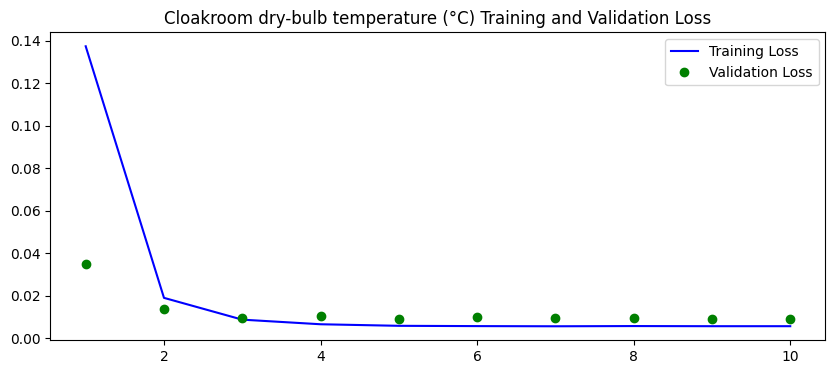

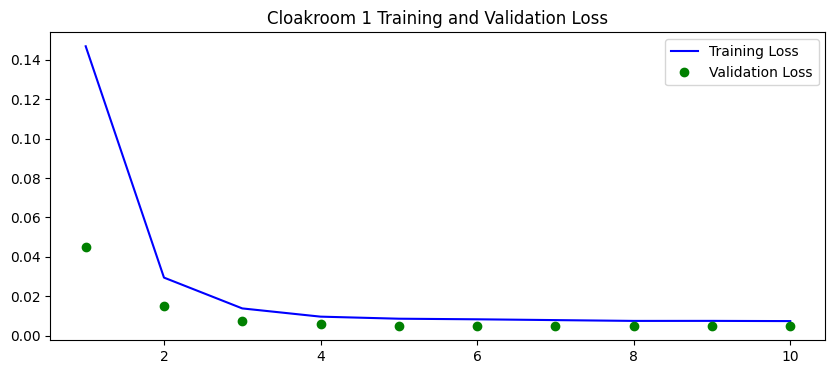

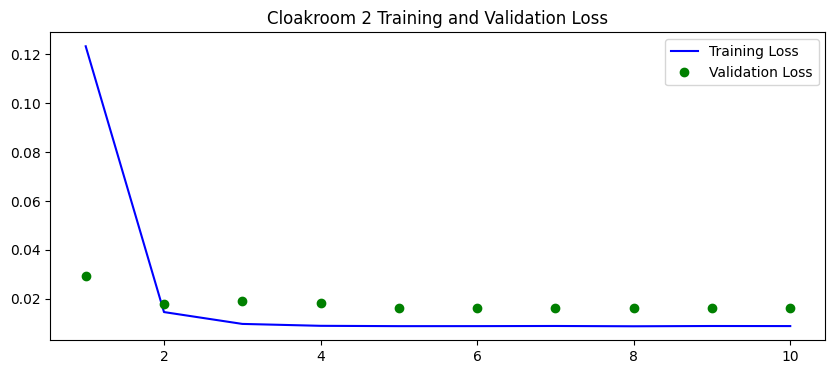

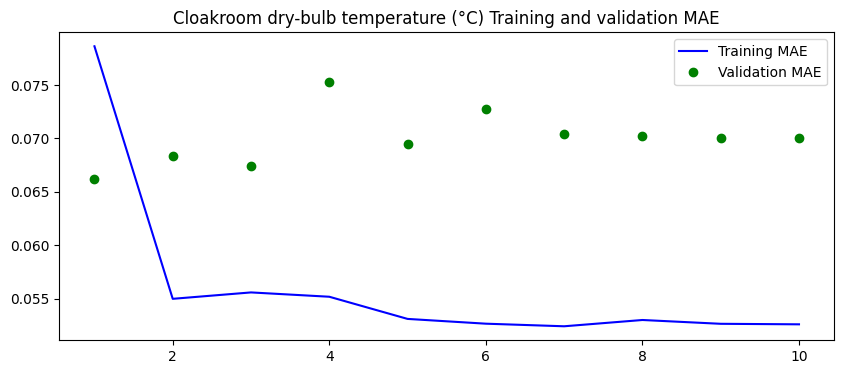

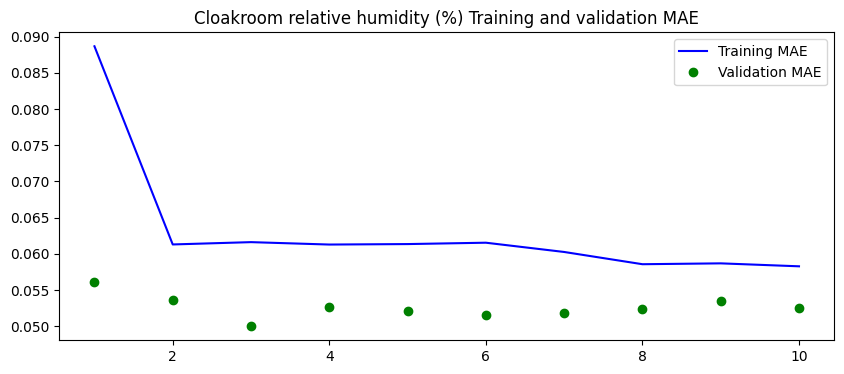

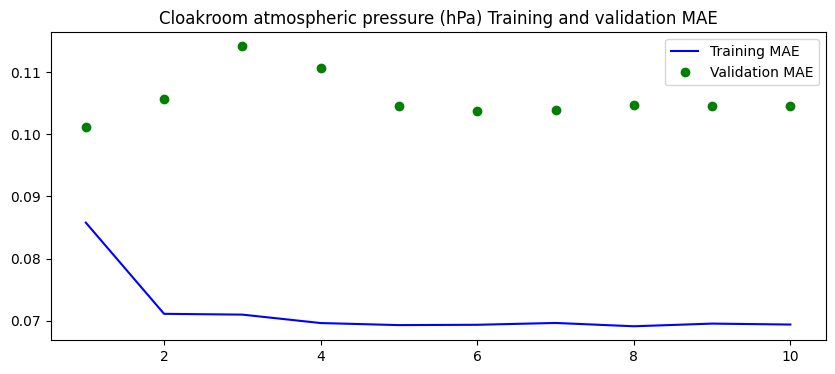

207/207 [==============================] - 3s 10ms/step


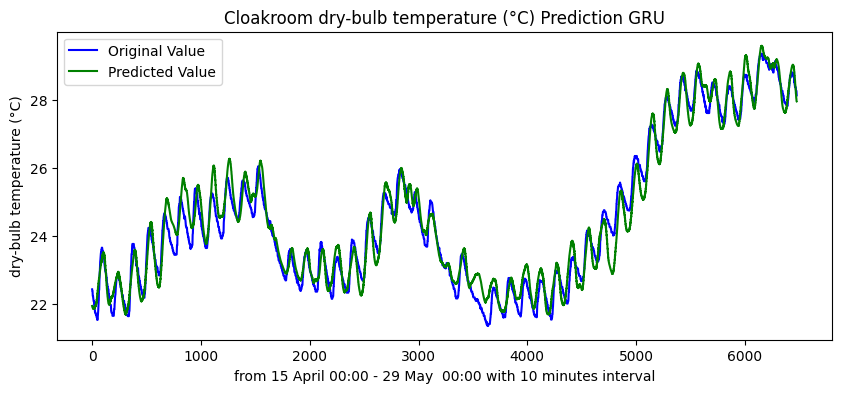

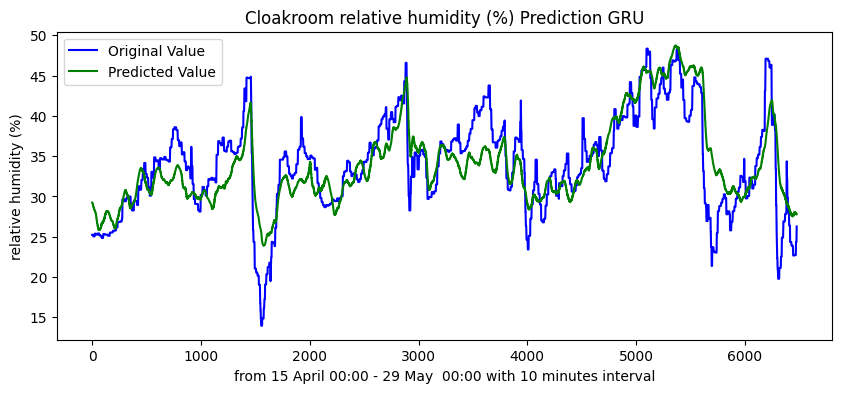

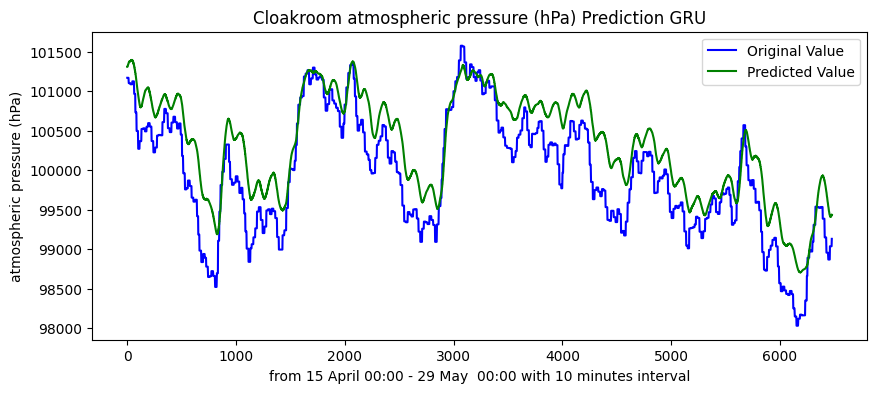

Room Number:0
MAE: 0.619
MSE: 0.608
R-squared: 0.874
RMSE: 3.058
Room Number:0
MAE: 4.596
MSE: 40.596
R-squared: -0.097
RMSE: 8.000
Room Number:0
MAE: 627.832
MSE: 564216.872
R-squared: 0.025
RMSE: 1085.160


In [ ]:
finish(model_name='GRU',room_number=0)

## Room 2 Forecasting

Epoch 1/10


<ipython-input-28-abe8d1818080>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen_list[room_number][attr],


500/500 [==============================] - 87s 169ms/step - loss: 0.1389 - mae: 0.0795 - val_loss: 0.0416 - val_mae: 0.0924 - lr: 0.0010
Epoch 2/10
500/500 [==============================] - 85s 169ms/step - loss: 0.0228 - mae: 0.0635 - val_loss: 0.0227 - val_mae: 0.1051 - lr: 0.0010
Epoch 3/10
500/500 [==============================] - 89s 177ms/step - loss: 0.0121 - mae: 0.0644 - val_loss: 0.0179 - val_mae: 0.1043 - lr: 0.0010
Epoch 4/10
500/500 [==============================] - 86s 172ms/step - loss: 0.0100 - mae: 0.0648 - val_loss: 0.0169 - val_mae: 0.1040 - lr: 0.0010
Epoch 5/10
500/500 [==============================] - 84s 169ms/step - loss: 0.0093 - mae: 0.0634 - val_loss: 0.0166 - val_mae: 0.1020 - lr: 0.0010
Epoch 6/10
500/500 [==============================] - 84s 168ms/step - loss: 0.0089 - mae: 0.0626 - val_loss: 0.0146 - val_mae: 0.0938 - lr: 0.0010
Epoch 7/10
500/500 [==============================] - 83s 167ms/step - loss: 0.0088 - mae: 0.0625 - val_loss: 0.0136 - val_

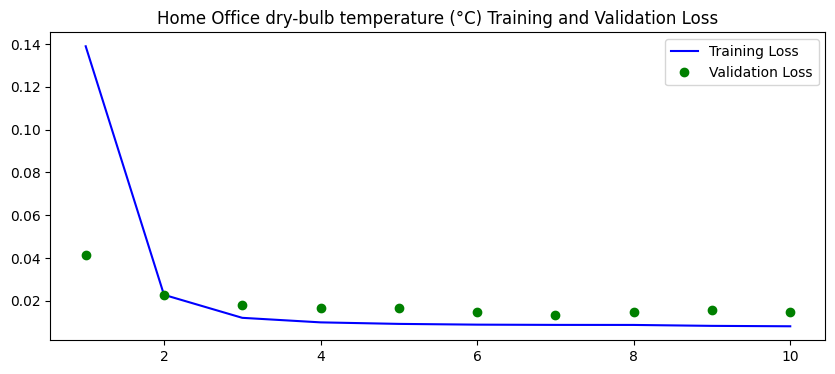

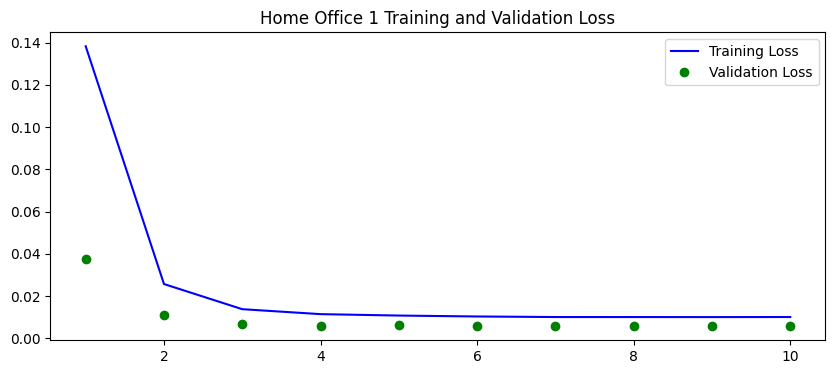

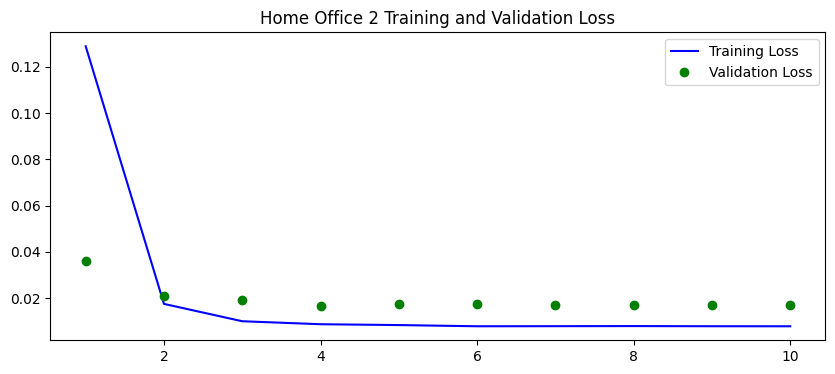

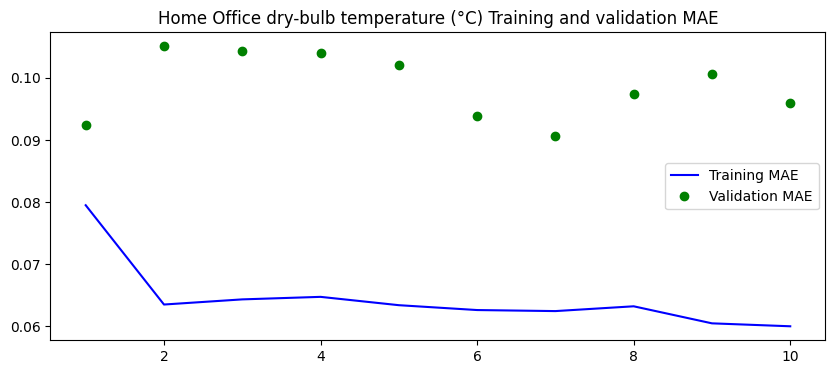

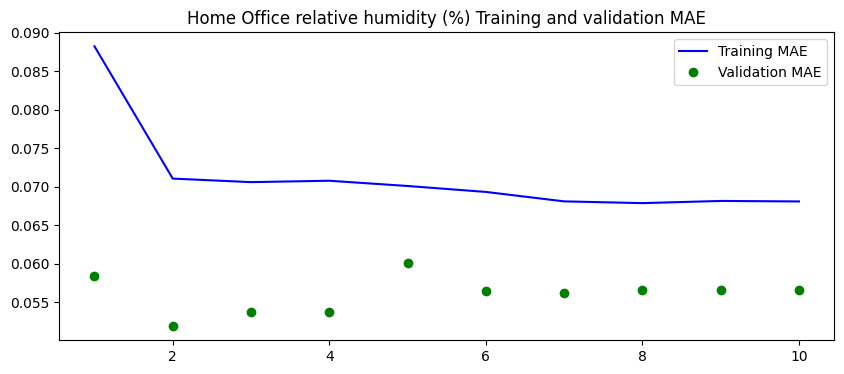

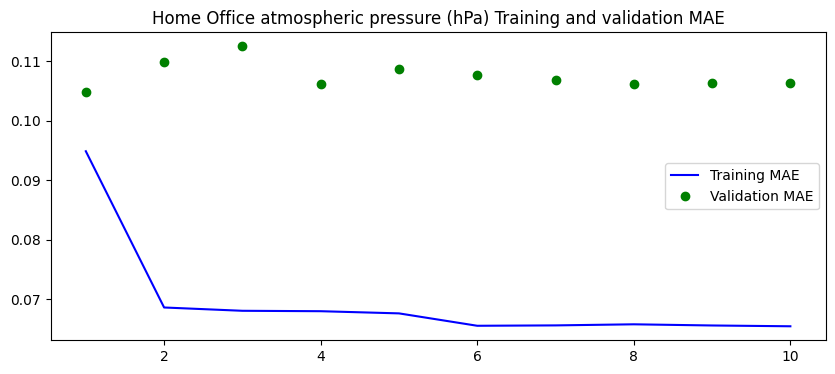

207/207 [==============================] - 4s 11ms/step



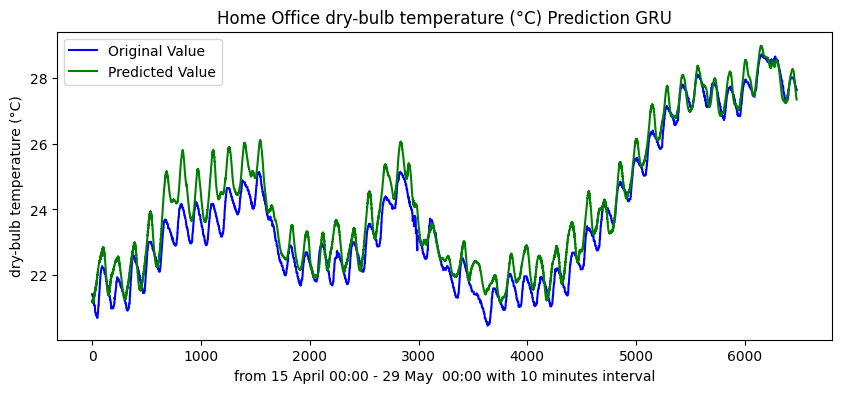

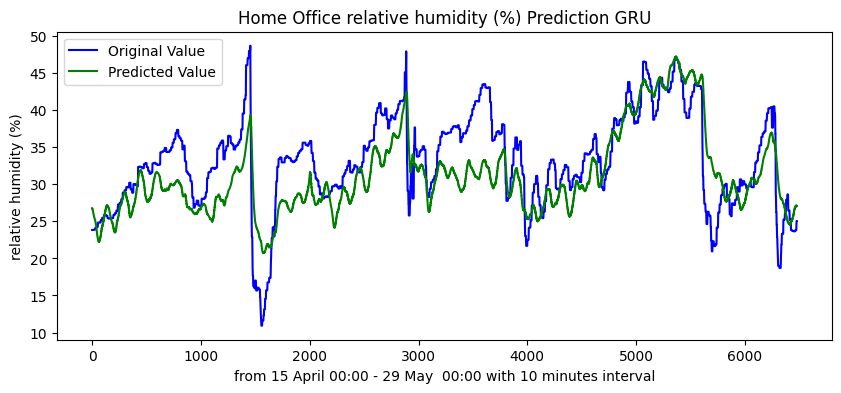

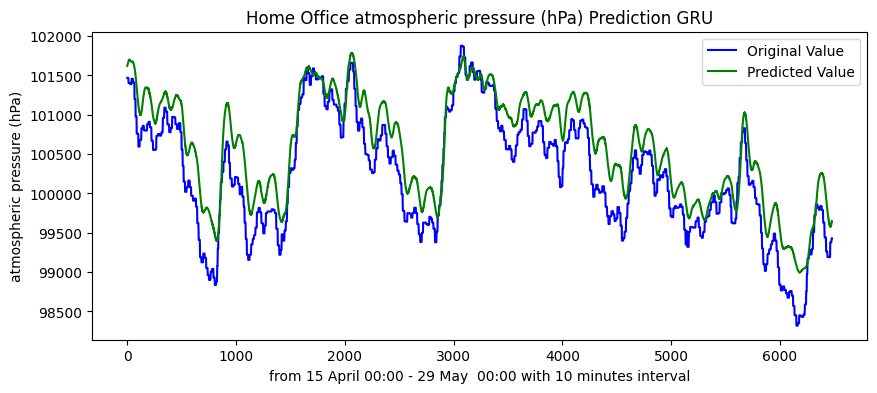


dry-bulb temperature (°C)
MAE: 0.588
MSE: 0.625
R-squared: 0.876
RMSE: 3.103

relative humidity (%)
MAE: 5.558
MSE: 51.945
R-squared: -0.274
RMSE: 8.681

atmospheric pressure (hPa)
MAE: 607.422
MSE: 535430.866
R-squared: 0.088
RMSE: 1098.532


In [ ]:
finish(model_name='GRU',room_number=1)

## Room 3 Forecasting

Epoch 1/10


<ipython-input-28-abe8d1818080>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen_list[room_number][attr],


500/500 [==============================] - 87s 169ms/step - loss: 0.1383 - mae: 0.0697 - val_loss: 0.0368 - val_mae: 0.0748 - lr: 0.0010
Epoch 2/10
500/500 [==============================] - 84s 169ms/step - loss: 0.0171 - mae: 0.0484 - val_loss: 0.0153 - val_mae: 0.0730 - lr: 0.0010
Epoch 3/10
500/500 [==============================] - 84s 167ms/step - loss: 0.0076 - mae: 0.0495 - val_loss: 0.0115 - val_mae: 0.0726 - lr: 0.0010
Epoch 4/10
500/500 [==============================] - 84s 169ms/step - loss: 0.0060 - mae: 0.0493 - val_loss: 0.0121 - val_mae: 0.0762 - lr: 0.0010
Epoch 5/10
500/500 [==============================] - 84s 169ms/step - loss: 0.0056 - mae: 0.0474 - val_loss: 0.0110 - val_mae: 0.0717 - lr: 1.0000e-04
Epoch 6/10
500/500 [==============================] - 83s 167ms/step - loss: 0.0055 - mae: 0.0476 - val_loss: 0.0116 - val_mae: 0.0746 - lr: 1.0000e-04
Epoch 7/10
500/500 [==============================] - 83s 165ms/step - loss: 0.0055 - mae: 0.0475 - val_loss: 0.010

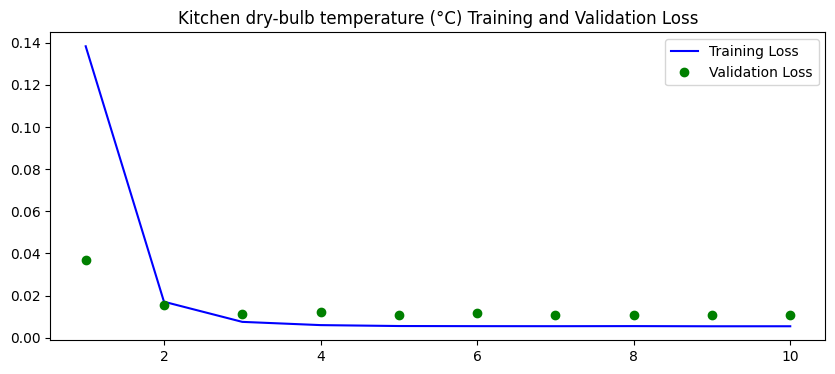

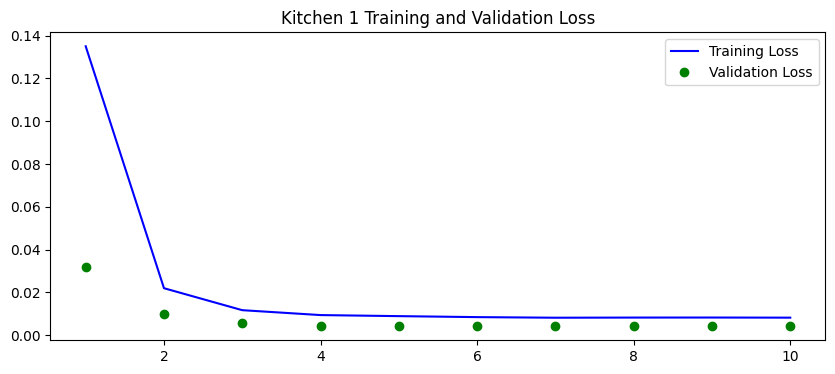

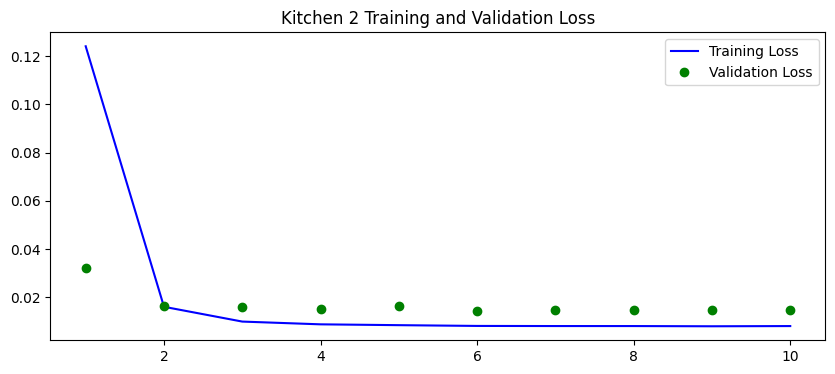

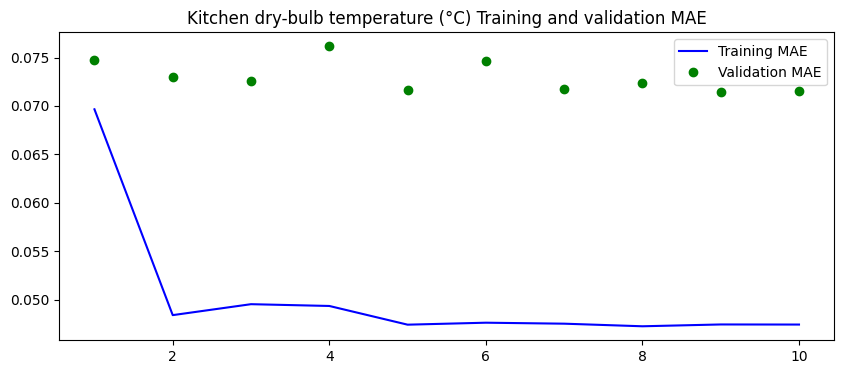

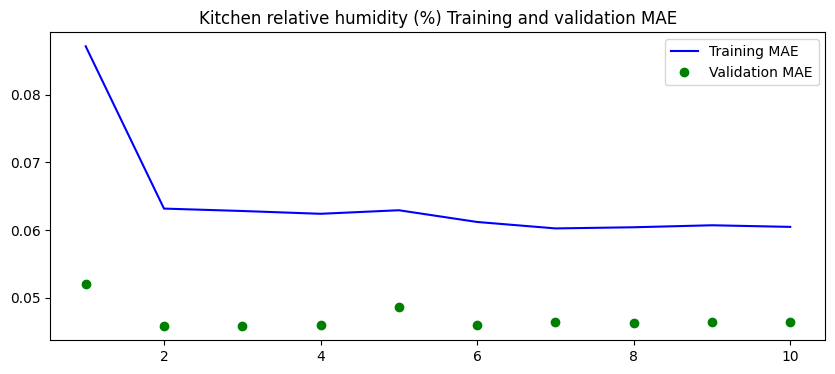

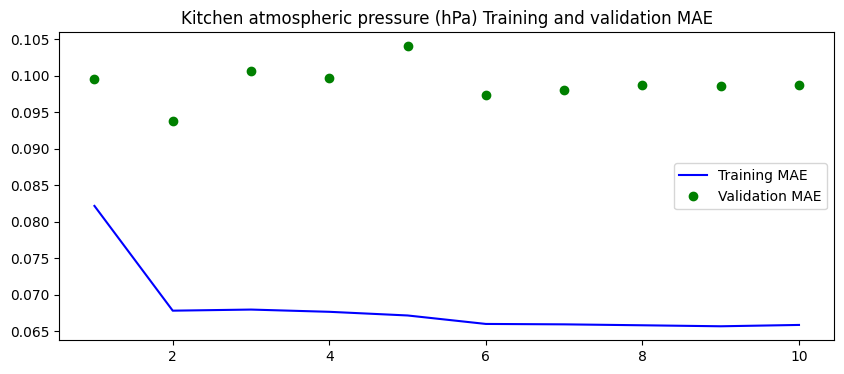

207/207 [==============================] - 3s 11ms/step



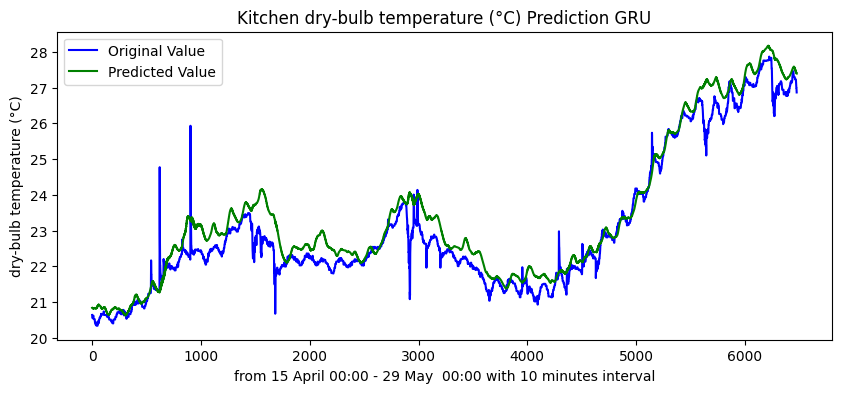

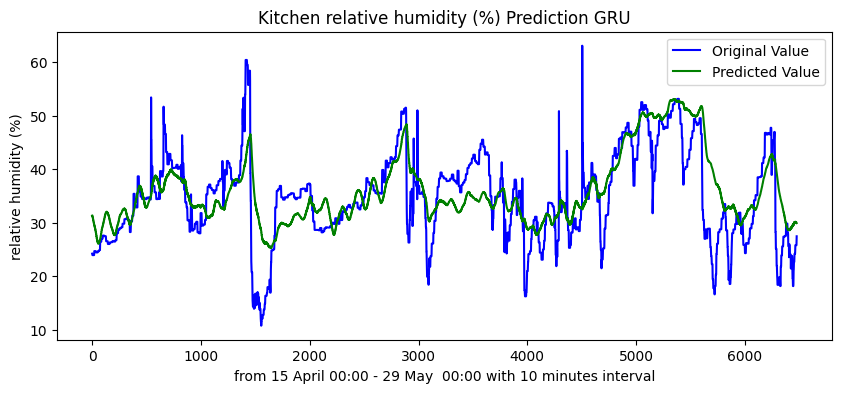

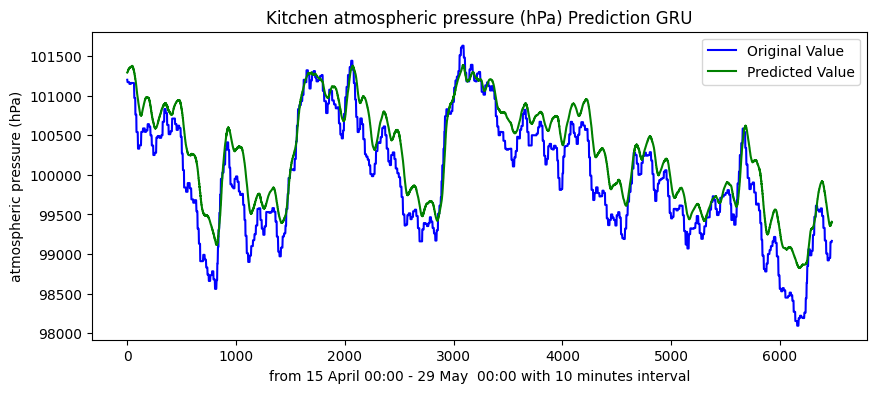


dry-bulb temperature (°C)
MAE: 0.531
MSE: 0.444
R-squared: 0.887
RMSE: 2.806

relative humidity (%)
MAE: 6.803
MSE: 83.589
R-squared: -0.206
RMSE: 10.566

atmospheric pressure (hPa)
MAE: 576.953
MSE: 498282.055
R-squared: 0.134
RMSE: 1057.328


In [ ]:
finish(model_name='GRU',room_number=2)

## Room 4 Forecasting

Epoch 1/10


<ipython-input-28-abe8d1818080>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen_list[room_number][attr],


500/500 [==============================] - 88s 171ms/step - loss: 0.1045 - mae: 0.0466 - val_loss: 0.0137 - val_mae: 0.0518 - lr: 0.0010
Epoch 2/10
500/500 [==============================] - 84s 168ms/step - loss: 0.0063 - mae: 0.0387 - val_loss: 0.0050 - val_mae: 0.0459 - lr: 0.0010
Epoch 3/10
500/500 [==============================] - 84s 169ms/step - loss: 0.0037 - mae: 0.0392 - val_loss: 0.0062 - val_mae: 0.0588 - lr: 0.0010
Epoch 4/10
500/500 [==============================] - 85s 170ms/step - loss: 0.0032 - mae: 0.0371 - val_loss: 0.0048 - val_mae: 0.0492 - lr: 1.0000e-04
Epoch 5/10
500/500 [==============================] - 84s 169ms/step - loss: 0.0032 - mae: 0.0374 - val_loss: 0.0045 - val_mae: 0.0475 - lr: 1.0000e-04
Epoch 6/10
500/500 [==============================] - 84s 169ms/step - loss: 0.0031 - mae: 0.0370 - val_loss: 0.0053 - val_mae: 0.0534 - lr: 1.0000e-04
Epoch 7/10
500/500 [==============================] - 84s 168ms/step - loss: 0.0030 - mae: 0.0369 - val_loss: 0

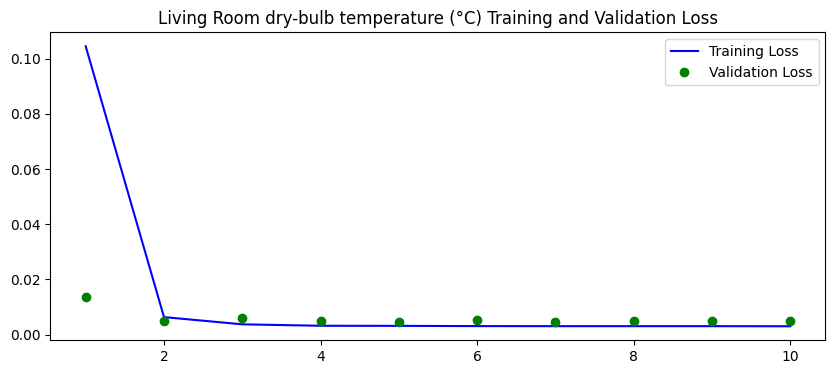

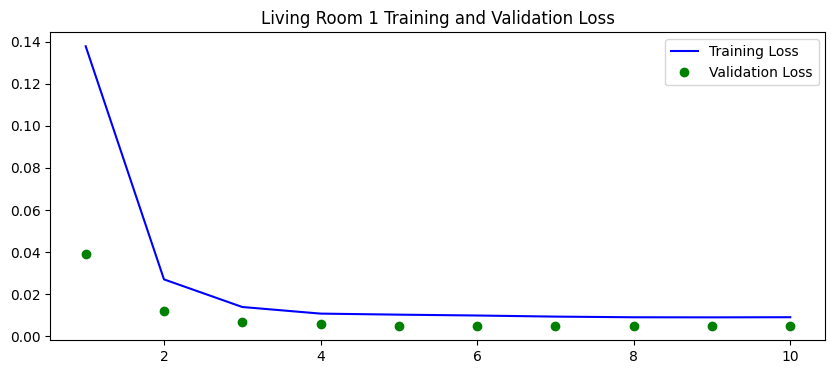

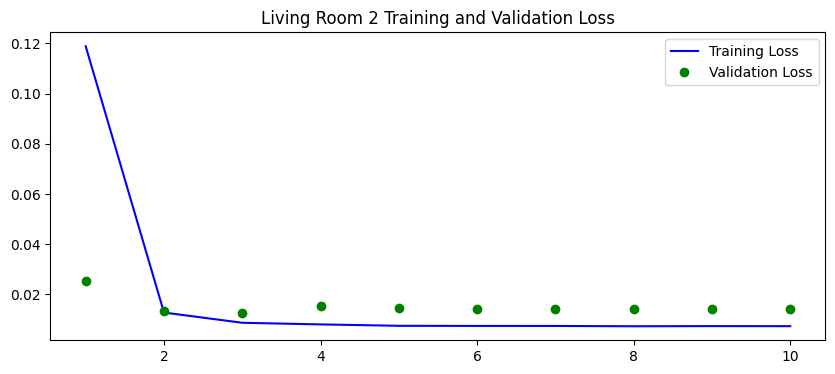

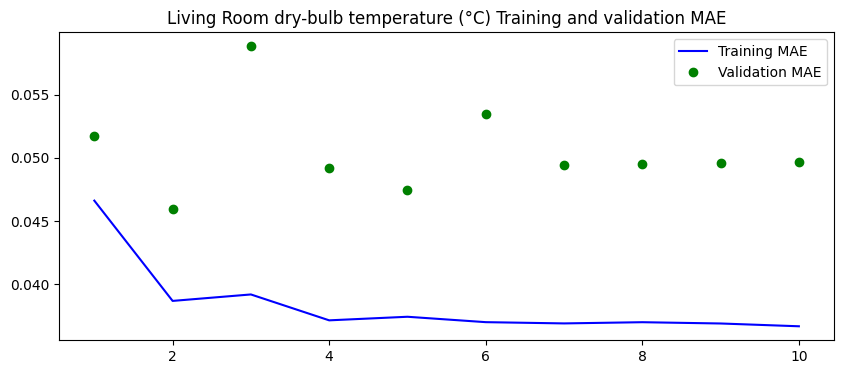

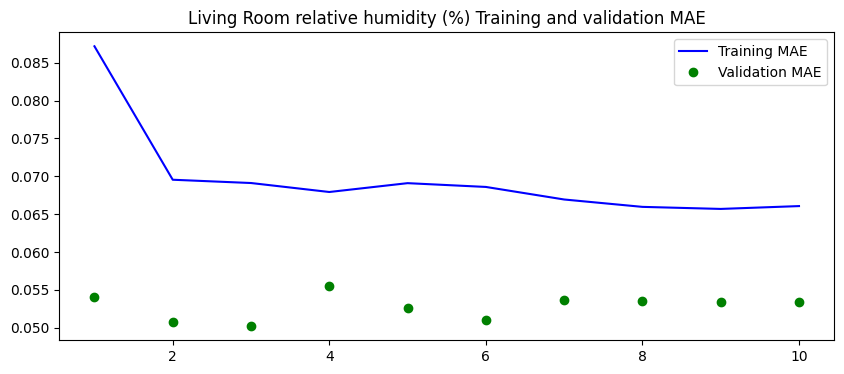

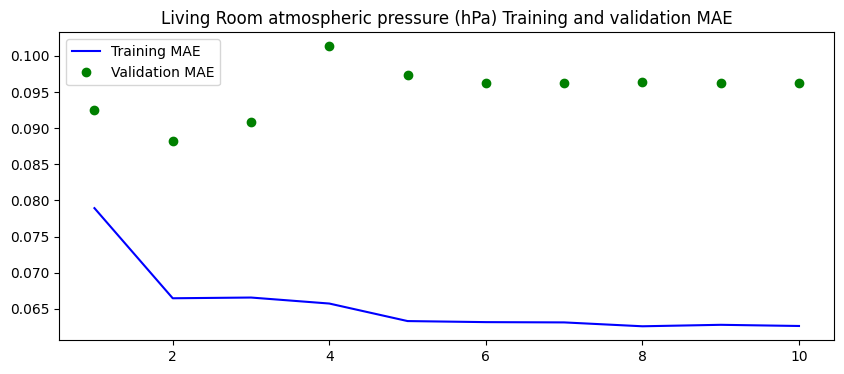

207/207 [==============================] - 3s 10ms/step



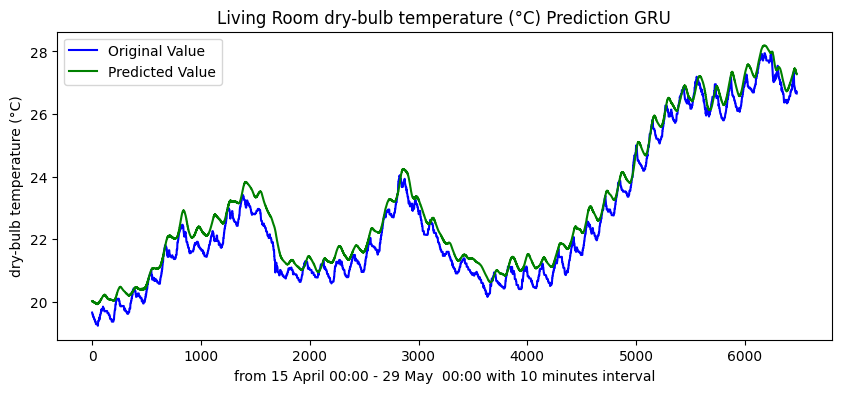

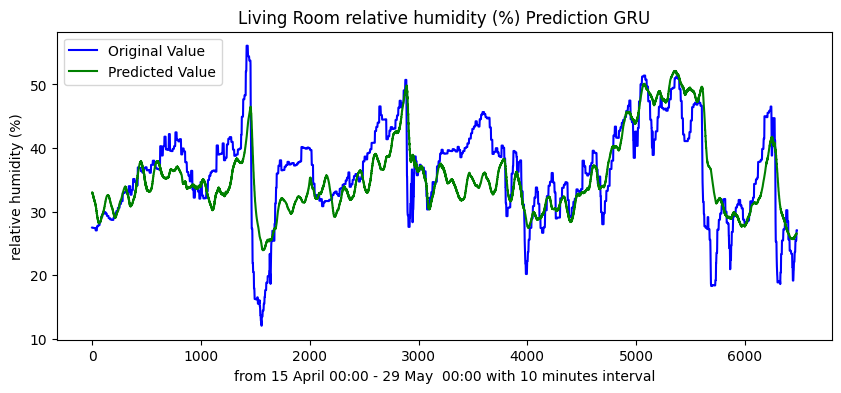

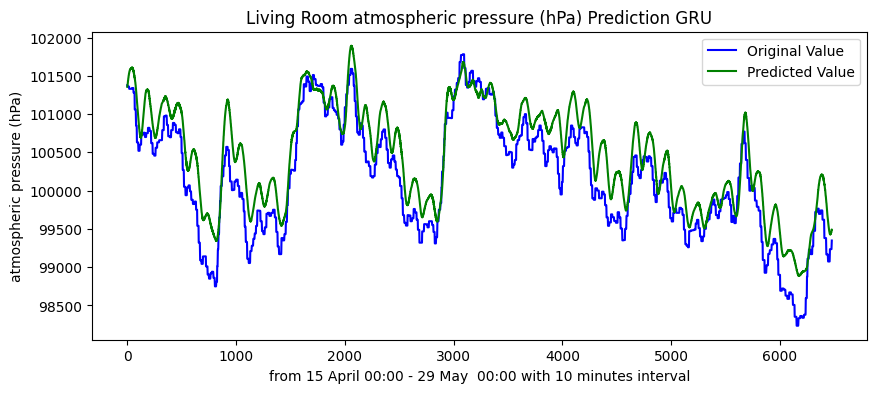


dry-bulb temperature (°C)
MAE: 0.497
MSE: 0.431
R-squared: 0.920
RMSE: 3.237

relative humidity (%)
MAE: 6.137
MSE: 69.422
R-squared: -0.283
RMSE: 9.522

atmospheric pressure (hPa)
MAE: 583.508
MSE: 510340.633
R-squared: 0.124
RMSE: 1086.067


In [ ]:
finish(model_name='GRU',room_number=3)

## Room 5 Forecasting

Epoch 1/10


<ipython-input-28-abe8d1818080>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen_list[room_number][attr],


500/500 [==============================] - 88s 170ms/step - loss: 0.1534 - mae: 0.0900 - val_loss: 0.0432 - val_mae: 0.0801 - lr: 0.0010
Epoch 2/10
500/500 [==============================] - 84s 169ms/step - loss: 0.0240 - mae: 0.0544 - val_loss: 0.0196 - val_mae: 0.0877 - lr: 0.0010
Epoch 3/10
500/500 [==============================] - 84s 169ms/step - loss: 0.0112 - mae: 0.0554 - val_loss: 0.0140 - val_mae: 0.0881 - lr: 0.0010
Epoch 4/10
500/500 [==============================] - 84s 169ms/step - loss: 0.0079 - mae: 0.0548 - val_loss: 0.0124 - val_mae: 0.0868 - lr: 0.0010
Epoch 5/10
500/500 [==============================] - 84s 169ms/step - loss: 0.0069 - mae: 0.0543 - val_loss: 0.0120 - val_mae: 0.0870 - lr: 0.0010
Epoch 6/10
500/500 [==============================] - 84s 169ms/step - loss: 0.0062 - mae: 0.0516 - val_loss: 0.0100 - val_mae: 0.0780 - lr: 0.0010
Epoch 7/10
500/500 [==============================] - 84s 169ms/step - loss: 0.0060 - mae: 0.0514 - val_loss: 0.0092 - val_

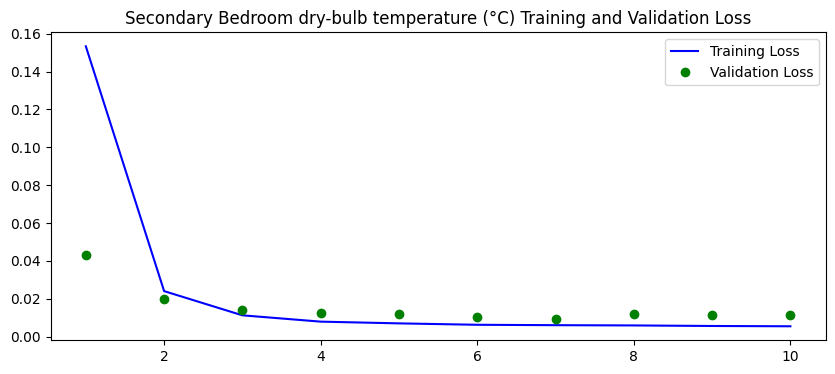

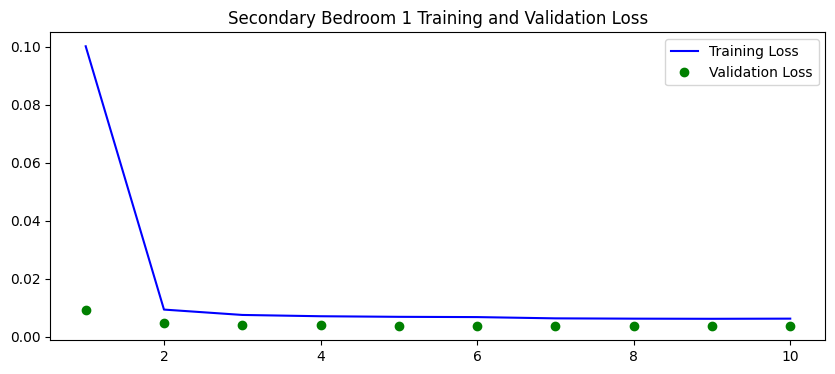

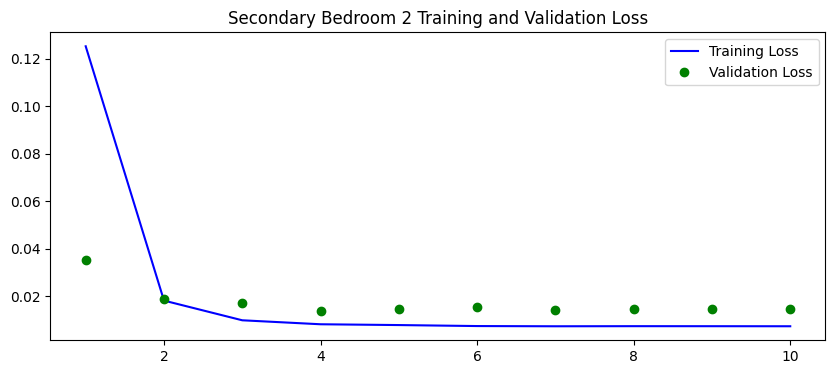

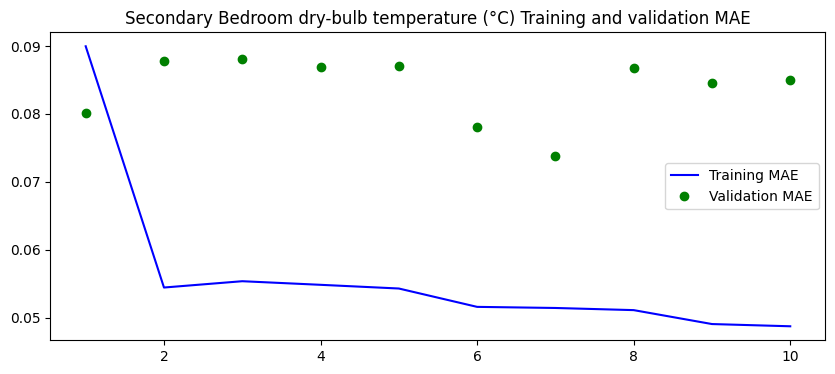

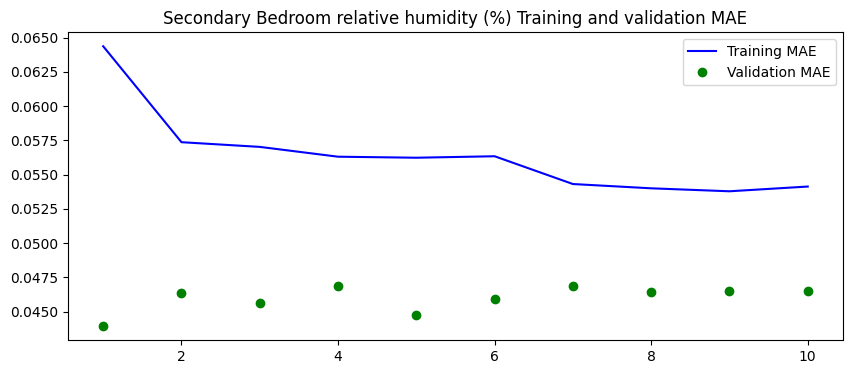

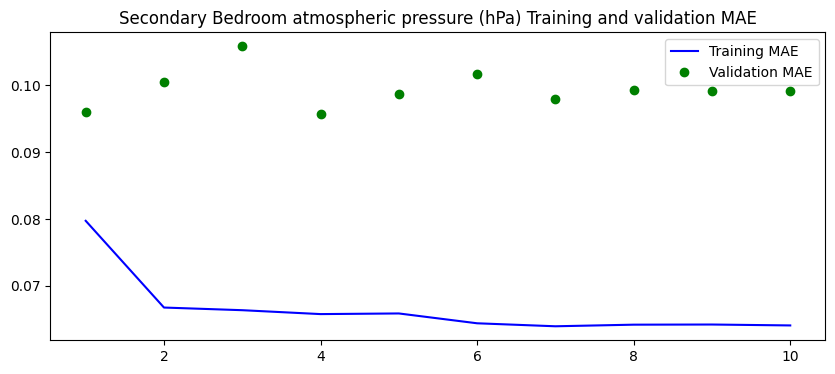

207/207 [==============================] - 3s 10ms/step



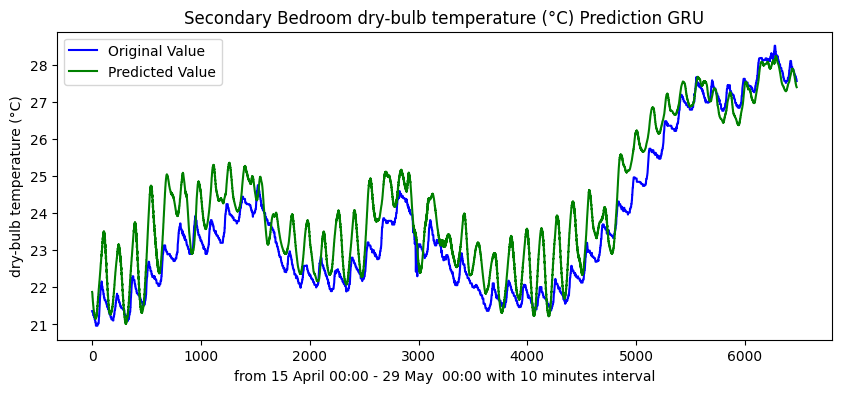

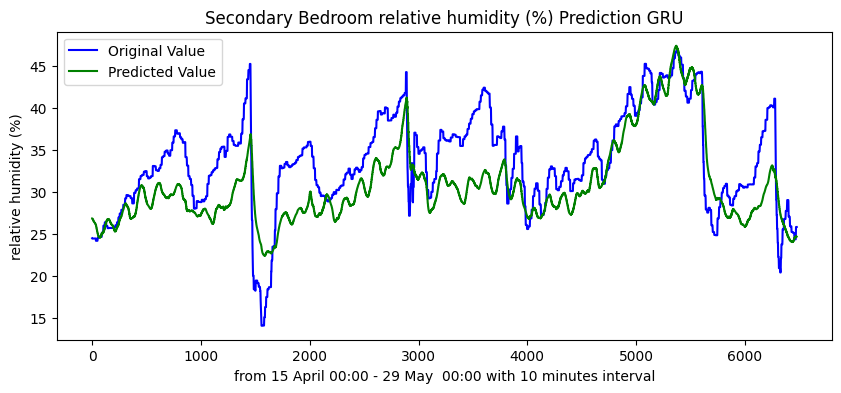

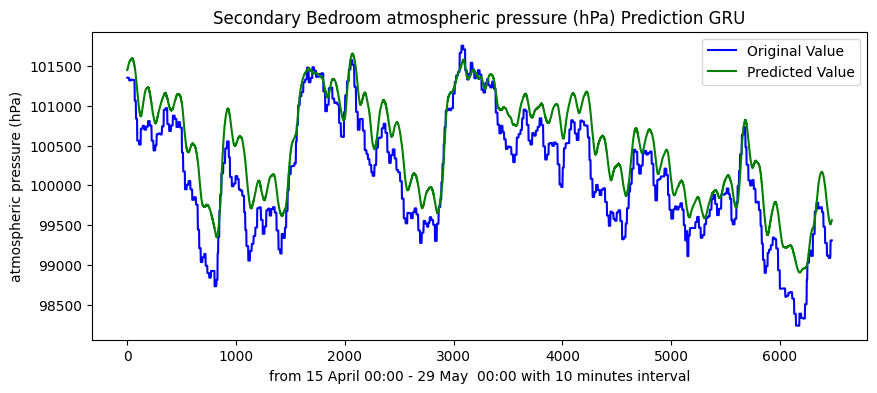


dry-bulb temperature (°C)
MAE: 0.627
MSE: 0.632
R-squared: 0.852
RMSE: 2.807

relative humidity (%)
MAE: 5.191
MSE: 41.820
R-squared: -0.236
RMSE: 8.138

atmospheric pressure (hPa)
MAE: 596.273
MSE: 521524.220
R-squared: 0.105
RMSE: 1081.289


In [75]:
finish(model_name='GRU',room_number=4)